In [1]:
import os
import time

# math
import numpy as np
from numpy.random import default_rng, SeedSequence
import pathos.multiprocessing as mp

# data manipulation
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def cranberry_passing_simulation(n_guests = 20, rng = default_rng()):
    '''
    Simulate cranberry passing process.
    
    Inputs:
      n_guests - number of guests at the table
      rng - random number generator, uses default_rng by default (:
    '''   
    
    # received_sauce is 1 if sauce has been received 0 otherwise
    received_sauce = np.zeros(n_guests, dtype='uint')
    
    # array whose i^th entry will be the i^th guest to receive 
    # the cranberry sauce
    received_order = np.zeros(n_guests, dtype='int')
    
    # initialize the problem
    current_position = 0
    received_sauce[current_position] = 1
    received_order[0] = 0
    n_received = 1
    n_passes = 0
    pos = [0]
    
    # iterate until everyone has received the cranberry sauce
    while n_received < n_guests:
        step = 2 * rng.integers(0, 1, endpoint =True) - 1
        
        current_position = (current_position + step) % n_guests
        pos.append(current_position)
        n_passes += 1
                
        if received_sauce[current_position] == 0:
            received_sauce[current_position] = 1
            received_order[n_received] = current_position
            n_received += 1
    
    received_last = received_order[-1]
        
    return received_last, n_passes

In [3]:
def repeat_cranberry_passing_simulation(n_guests = 20, n_simulations = 10, 
                                        rng = default_rng()):
    '''
    Repeat the cranberry passing simulation.
    
    Inputs:
      n_guests - number of guests at the table
      n_simulations - number of runs to simulate
      rng - random number generator, uses default_rng by default (:
    '''   
    
    # simulation results has an array with columns: received_last, n_passes
    sim_rslts = np.zeros((n_simulations, 2), dtype = 'int')
        
    # simulate
    for i in range(n_simulations):
        sim_rslts[i] = cranberry_passing_simulation(n_guests = n_guests, rng = rng)
    
    # add labels to columns
    sim_rslts = pd.DataFrame(sim_rslts, columns = ['received_last', 'n_passes'])
    
    return sim_rslts

In [4]:
def repeat_cranberry_passing_simulation_mp(n_guests = 20, n_simulations = 10, n_cores = 1, 
                                           seed = None):
    '''
    Multi-processing version of repeated cranberry passing simulation.
    
    Inputs:
      n_guests - number of guests at the table
      n_simulations - number of runs to simulate
      n_cores - number of multiprocessing threads to use 
      seed - random number generator seed, if none is provided, sets it randomly
    '''
    
    # produce a default seed if none ins provided
    if seed is None:
        seed = int(time.time())
    
    # set up rng to run in parallel reproducibly if seed was provided
    ss = SeedSequence(seed)
    child_seeds = ss.spawn(n_cores)
    streams = [default_rng(s) for s in child_seeds]
    
    # simulations per core
    n_sim_per_core = [n_simulations // n_cores for i in range(n_cores)]
    n_sim_per_core[0] = n_sim_per_core[0] + (n_simulations % n_cores)
    
    # perform the simulations on each core
    with mp.Pool(n_cores) as p:
        sim_rslts = p.map(
            lambda x: repeat_cranberry_passing_simulation(n_guests = n_guests, 
                                                          n_simulations = x[0], 
                                                          rng = x[1]), 
            zip(n_sim_per_core, streams)
        )
        
    # union all the result dataframes together
    sim_rslts = (pd.concat(sim_rslts, axis='rows')
                 .reset_index()
                 .drop(columns = ['index']))
            
    return sim_rslts

In [5]:
%%time
n_guests = 20
sim_rslts = repeat_cranberry_passing_simulation_mp(n_guests=n_guests, 
                                                   n_simulations = int(1e6), 
                                                   n_cores = 16, 
                                                   seed = 12345)

CPU times: user 65.6 ms, sys: 65.1 ms, total: 131 ms
Wall time: 1min


Text(0.5, 0, 'k')

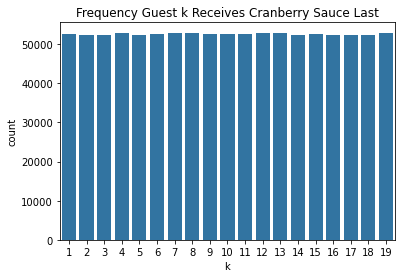

In [6]:
fig, ax = plt.subplots(facecolor='white')
g = sns.countplot(data = sim_rslts, x='received_last', color = 'C0', ax=ax)
g.set_title('Frequency Guest k Receives Cranberry Sauce Last')
g.set_xlabel('k')

In [7]:
counts, bins = np.histogram(sim_rslts.received_last, bins=np.arange(n_guests + 1))
counts

array([    0, 52720, 52447, 52355, 52848, 52356, 52519, 52835, 52785,
       52687, 52729, 52747, 52957, 52916, 52486, 52538, 52442, 52388,
       52335, 52910])

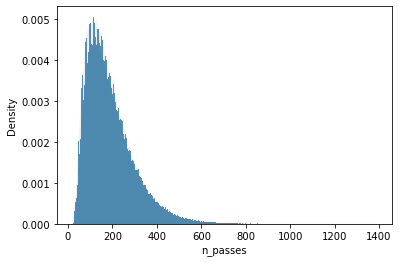

In [8]:
fig, ax = plt.subplots(facecolor='white')
sns.histplot(data = sim_rslts, x='n_passes', stat = 'density', discrete = True, ax=ax)

In [9]:
sim_rslts.mean()

received_last     10.000034
n_passes         189.848918
dtype: float64

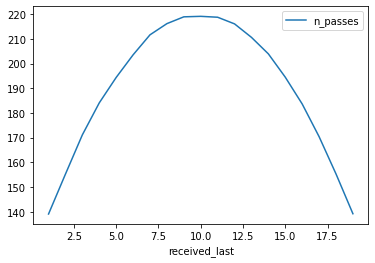

In [10]:
fig, ax = plt.subplots(facecolor='white')
sim_rslts.groupby('received_last').mean().plot(ax=ax)